# DeepJetCore Example

Example from [DeepJetCore](). Try several tools


* [LCG Views](http://lcginfo.cern.ch/)
* Interactive Analysis [Jupyter Root Integration](https://root.cern.ch/notebooks/HowTos/HowTo_ROOT-Notebooks.html)
* Efficent analysis with [RDataFrame](https://root.cern.ch/doc/master/group__tutorial__dataframe.html) in Python
* Python JIT Compilation with [Numba in ROOT](https://root.cern.ch/doc/master/pyroot004__NumbaDeclare_8py.html)

## Setup

    source /cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-clang10-opt/setup.sh
    root --notebook
    
For remote viewing use ssh Tunnels

    ssh -L 8888:localhost:8888


In [2]:
# Define Input Data, a tree of 10000 images generated by DeepJetCore

import os
import ROOT

INPUT_FILENAMES = '/local/dliko/working/DJCTraining/example_data/train_files.txt'
INPUT_DIR = os.path.dirname(INPUT_FILENAMES)

INPUT_FILES = (os.path.join(INPUT_DIR, name.strip()) for name in open(INPUT_FILENAMES, 'r').readlines())

df = ROOT.RDataFrame('tree', INPUT_FILES)

for name in df.GetColumnNames():
    print ( '{} : {}'.format(name,df.GetColumnType(name)) )           
print ('\nNumber of Entries = {}'.format(df.Count().GetValue()))

# Define various statistic calculations for image

df = df.Define('mu_x','Dot(xcoords,image)/Sum(image)')\
       .Define('mu_y','Dot(ycoords,image)/Sum(image)')\
       .Define('var_x','Dot(xcoords*xcoords,image)/Sum(image) - mu_x*mu_x')\
       .Define('cov_xy','Dot(xcoords*ycoords,image)/Sum(image) - mu_x*mu_y')\
       .Define('var_y','Dot(ycoords*ycoords,image)/Sum(image) - mu_y*mu_y')\
       .Define('sig_x','sqrt(var_x)') \
       .Define('sig_y','sqrt(var_y)') \
       .Define('cor_xy','cov_xy/(sig_x*sig_y)')

image : ROOT::VecOps::RVec<float>
image2d : ROOT::VecOps::RVec<vector<float>>
sigfrac : ROOT::VecOps::RVec<float>
sigfrac2d : ROOT::VecOps::RVec<vector<float>>
xcoords : ROOT::VecOps::RVec<float>
ycoords : ROOT::VecOps::RVec<float>
sigsum : Float_t
size : Int_t
isA : Int_t
isB : Int_t
isC : Int_t

Number of Entries = 10000


## Events

Each event is a generated image with an 2-dim gaussian peak at an random position. There are three classes A,B, C. For each class the parametrs follow a different pattern. 

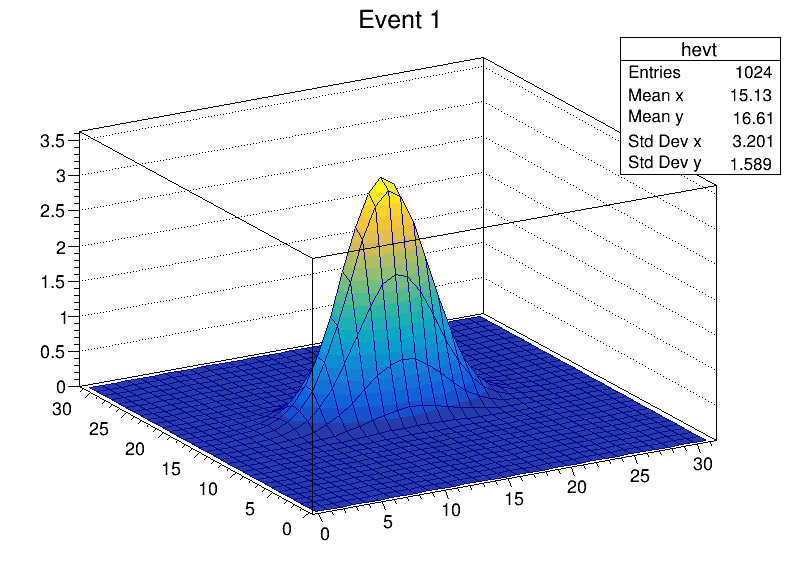

In [3]:
# Show first event
evt1 = df.Range(1).AsNumpy(columns=['image','xcoords','ycoords'])

image = evt1['image'][0]
xcoords = evt1['xcoords'][0]
ycoords = evt1['ycoords'][0]

hevt = ROOT.TH2F("hevt","Event 1",32,-0.5,31.5,32,-0.5,31.5)

for i in range(1024):
    hevt.Fill(xcoords[i],ycoords[i],image[i])

c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
hevt.Draw('surf1')
c.Draw()

## Eventclasses

There are three classes A,B, C. For each class the parametrs follow a different pattern.

Number of Entries for A = 3340
Number of Entries for B = 3330
Number of Entries for C = 3330


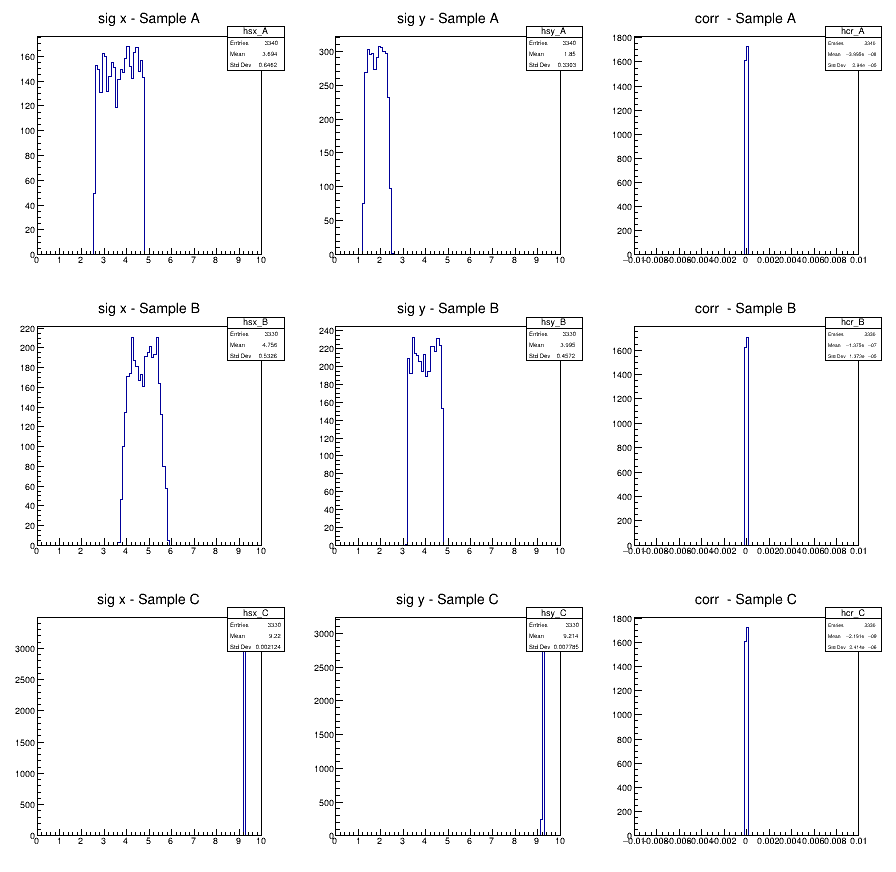

In [11]:
#@ROOT.Numba.Declare(['RVec<float>','RVec<float>'], 'float')
#def imgcentery(image,coor):
#    center = 0
#    norm = 0
#    for w, c in zip(image,coor):
#        center += c * w
#        norm += w
#    return center / norm
#
#df = df.Define('xcen','Numba::imgcentery(image,xcoords)') \
#       .Define('ycen','Numba::imgcentery(image,ycoords)')

#df = df.Define('xcen','Dot(xcoords,image)/Sum(image)')\
#       .Define('ycen','Dot(xcoords,image)/Sum(image)')

dfs = {}
hxy = {}
hsx = {}
hsy = {}
hcr = {}
for s in [ 'A', 'B', 'C']:

    dfs[s] = df.Filter('is%s' % s)

    hxy[s] = dfs[s].Histo2D(
        ROOT.RDF.TH2DModel('hxy_%s' % s, 'mu - Sample %s' % s, 10, 10, 0, 31, 0, 31),
        'mu_x', 'mu_y')

    hsx[s] = dfs[s].Histo1D(
        ROOT.RDF.TH1DModel('hsx_%s' % s, 'sig x - Sample %s' % s, 100, 0, 10),
        'sig_x')
    hsy[s] = dfs[s].Histo1D(
        ROOT.RDF.TH1DModel('hsy_%s' % s, 'sig y - Sample %s' % s, 100, 0, 10),
        'sig_y')
    hcr[s] = dfs[s].Histo1D(
        ROOT.RDF.TH1DModel('hcr_%s' % s, 'corr  - Sample %s' % s, 100, -0.01, 0.01),
        'cor_xy')

for s in [ 'A', 'B', 'C' ]:
    print ('Number of Entries for {} = {}'.format(s,dfs[s].Count().GetValue()))

#sx_A = df_A.Histo1D(ROOT.RDF.TH1DModel("sx_A", "sigma_x A", 100, 0, 10),'s_x')
c = ROOT.TCanvas("myCanvasName","The Canvas Title",900,900)
c.Divide(3,3)
c.cd(1)
hsx['A'].Draw()
c.cd(2)
hsy['A'].Draw()
c.cd(3)
hcr['A'].Draw()
c.cd(4)
hsx['B'].Draw()
c.cd(5)
hsy['B'].Draw()
c.cd(6)
hcr['B'].Draw()
c.cd(7)
hsx['C'].Draw()
c.cd(8)
hsy['C'].Draw()
c.cd(9)
hcr['C'].Draw()
c.Draw()

In [ ]:
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
f = ROOT.TF1('x','x',100,-10,10)
f.Draw()
c.Draw()